# META-VQE PARA XXZ

Implementaremos el algoritmo de [Cervera-Lierta et al. (2021)](https://arxiv.org/abs/2009.13545). Utilizaremos el paquete de $\verb|tequila|$ al igual que los autores para reproducir los resultados.

In [2]:
### IMPORTACIÓN DE PAQUETES ###

import tequila as tq
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

Definimos una semilla para poder replicar los resultados.

In [3]:
# SEMILLA

def seed_gen(string):
    num_str = [ord(letter) - 96 for letter in string]
    # seed must be between 0 and 2**32 - 1
    return(np.mod(int(''.join(map(str,num_str))),2**32 - 1))

np.random.seed(seed_gen('raquel'))

## ALGORITMO META-VQE

Buscamos minimizar la función de coste asociada al hamiltoniano de Heisenberg-Ising:

$$H = \sum_{i=1}^n \sigma_i^x \sigma_{i+1}^x + \sigma_i^y \sigma_{i+1}^y + \Delta \sigma_i^z \sigma_{i+1}^z + \lambda \sum_{i=1}^n \sigma_i^z,$$

donde $\Delta$ es el parámetro de anisotropía y $\lambda$ la fuerza de campo transversal. Vamos a llevar a cabo dos procesos de optimización: uno para aprender el perfil de la función y otro para aproximar al estado fundamental.

En ambos casos, tomaremos un conjunto de 20 puntos equiespaciados entre $-1.1 < \Delta < 1.1$ para entrenar el algoritmo y luego lo evaluaremos en $100$ valores de $\Delta$ no equiespaciados. A efectos de este entrenamiento, tomaremos $\lambda = 0.75$ constante.


Usaremos un circuito de 4 cúbits con 2 capas de codificación y 2 de procesado. Más adelante, modificaremos el número de capas para comprobar cómo cambia el comportamiento del modelo.

In [4]:
### INPUT ###

# Número de qubits 

nqubits = 4

# Número de capas

nlayers = [2,2] # [codificación, procesado]

# Parámetros del Hamiltoniano

Delta_train = np.linspace(-1.1, 1.1, num=20)
Delta_test = [np.random.uniform(-1.1, 1.1) for i in range(100)]
Delta_test.sort()
lambXXZ = 0.75

# Parámetros de optimización
methods = 'BFGS'
grad_methods = '2-point'
backend = 'qulacs'
lr = 0.01
mthd_opt = {'finite_diff_rel_step': 0.0001}

### Construcción del hamiltoniano

Vamos a construir el hamiltoniano anteriormente mencionado

$$H = \sum_{i=1}^n \sigma_i^x \sigma_{i+1}^x + \sigma_i^y \sigma_{i+1}^y + \Delta \sigma_i^z \sigma_{i+1}^z + \lambda \sum_{i=1}^n \sigma_i^z.$$

Para ello, aplicamos las matrices de Pauli $\sigma^x$, $\sigma^y$ y $\sigma^z$ a los correspondientes cúbits. Hemos de tener en cuenta que estamos trabajando en un sistema de dos partículas, por lo que los productos tensoriales tendrán dimensión $4\times4$. Siendo así, si no se menciona una de las puertas, se entiende que se está aplicando la identidad, como es el caso de $\sigma_i^z$, el cual sería $\sigma_i^z \otimes I_{i+1}$.

Por otro lado, vamos a aplicar condiciones de contorno periódicas, por lo que el sumatorio no sólo se limita a los cúbits $q_i$, $q_{i+1}$ con $i \in \{ 1, 2, \dots, n\}$, sino que también se enlazarán los cúbits $q_1$ y $q_n$, es decir, habrá que añadir los términos $\sigma_{n}^x \sigma_{1}^x$ (análogo para $\sigma^y$ y $\sigma^z$).

El hamiltoniano nos servirá para evaluar la función de coste en cada optimización del circuito.



In [5]:
# Construcción del hamiltoniano

def hamiltonian(numqubits, Delta, lamb):
    
    ham = tq.paulis.X(numqubits-1)*tq.paulis.X(0) 
    ham += tq.paulis.Y(numqubits-1)*tq.paulis.Y(0) 
    ham += Delta*tq.paulis.Z(numqubits-1)*tq.paulis.Z(0)
    ham += lamb*tq.paulis.Z(numqubits-1)
    for i in range(numqubits-1):
        ham += tq.paulis.X(i)*tq.paulis.X(i+1)
        ham += tq.paulis.Y(i)*tq.paulis.Y(i+1)
        ham += Delta*tq.paulis.Z(i)*tq.paulis.Z(i+1)
        ham += lamb*tq.paulis.Z(i)
    return(ham)

Podemos resolver $H$ de manera exacta para comparar posteriormente su estado fundamental con el resultado de la minimización.

In [6]:
# Valor exacto del hamiltoniano

def exact(numqubits, Delta, lamb):
    
    ham = hamiltonian(numqubits, Delta, lamb).to_matrix()
    energ = np.linalg.eigvals(ham)
    
    return min(energ)

### Construcción del circuito

Construimos ahora el circuito que nos permitirá evaluar el valor esperado del hamiltoniano. 

Primeramente, abrimos un circuito vacío.

A continuación, generamos las variables que tendrá el circuito. Comenzaremos abriendo dos variables $\verb|phi|$ y $\verb|theta|$, que aprovecharemos tanto para la capa de codificación ($\verb|Delta=!0|$) como para la de procesado ($\verb|Delta==0|$). En el caso de la capa de codificación, que recordemos que tenía los parámetros

$$ R(f(\Delta, \vec{\varphi_{ql}})) = R_z (w_{ql}^{z} \Delta + \phi_{ql}^{z}) R_y(w_{ql}^{y} \Delta + \phi_{ql}^{y}).$$

con subíndices $(q,l)$ haciendo referencia al cúbit $q_i$ y a la capa $l$, las variables serán $\verb|phi|=\phi_{ql}^{(z)}$ y $\verb|theta|=\phi_{ql}^{(y)}$. A mayores, tendremos que abrir dos nuevas variables para los pesos $\verb|w2|=w_{ql}^z$ y $\verb|w1|=w_{ql}^y$.

Por el contrario, si nos encontramos en una capa de procesado, con las variables $\verb|phi|=\theta_{ql}^{(z)}$ y $\verb|theta|=\theta_{ql}^{(y)}$ será suficiente.

$$ R(\vec{\theta_{ql}}) = R_z (\theta_{ql}^{z}) R_y(\theta_{ql}^{y})$$

De esta manera, por cada capa de codificación generamos cuatro variables $\verb|theta|, \verb|phi|, \verb|w1|, \verb|w2|$, a las que añadiremos a su nomenclatura el cúbit $q$ y la capa $l$ en la que se encuentren; por ejemplo $\verb|theta|_{2,3}$ se refiere a la variable $\verb|theta|$ de la rotación sobre el eje $Y$ que se encuentra en la capa $2$ y actúa sobre el cúbit $q_3$.

Veamos un ejemplo: supongamos que tenemos $4$ cúbits, $2$ capas de codificación y $2$ capa de procesado. Entonces en las capas de codificación tendremos $4$ variables por cada cúbit y por cada capa, luego $32$ variables, mientras que en la de procesado tendremos $2$ variables por cúbit y capa, entonces $16$ variables. En total, serían $48$ variables. 

Por último, añadimos las puertas $CNOT$ que unirán cúbits contiguos alternando estas uniones en función de si la capa es par o no.

In [7]:
### CIRCUITO ###

def quantum_circuit(numqubits, numlayers, Delta, var_name):
    
    circuit = tq.QCircuit()

    for li in range(numlayers):
    
        for qi in range(numqubits):
            
            theta = tq.Variable(name="{}t_{}{}".format(var_name, li, qi))
            phi = tq.Variable(name="{}p_{}{}".format(var_name, li, qi))
            
            if Delta!=0: #codificación
                w1 = tq.Variable(name="{}w1_{}{}".format(var_name, li, qi))
                w2 = tq.Variable(name="{}w2_{}{}".format(var_name, li, qi))
                circuit += tq.circuit.gates.Rz(w2*Delta + phi, qi) + tq.circuit.gates.Ry(w1*Delta + theta, qi)
                
            if Delta==0: #procesado
                circuit += tq.circuit.gates.Rz(phi,qi) + tq.circuit.gates.Ry(theta,qi)


        for qi in range(li%2, numqubits-1, 2):
                circuit += tq.circuit.gates.CNOT(control=qi,target = qi+1)
               
    return(circuit)


### Optimización

En la primera minimización, tan solo obtendremos el perfil de la función para establecer un buen punto de partida para las variables de la segunda. Por tanto, generaremos 20 circuitos y sumaremos todas sus variables en la siguiente función de coste:

$$ C (\vec{\Theta}) = \sum_{i=1}^M \langle \varphi (\vec{\Theta}_i, \Delta_i) | H (\Delta_i) | \varphi_i (\vec{\Theta}_i, \Delta_i) \rangle $$

Es decir, debemos calcular el valor esperado del operador $H$ con el valor de $\Delta_i$ que corresponda en cada caso, sobre el estado del circuito $|\varphi (\vec{\Theta_i}, \Delta_i \rangle$. 

In [8]:
### FUNCIÓN DE COSTE ###

costf = tq.Objective()

for i in range(len(Delta_train)):
    
    ham = hamiltonian(nqubits, Delta_train[i], lambXXZ)
    fullcircuit = quantum_circuit(nqubits, nlayers[0], Delta_train[i], "th_enc") + quantum_circuit(nqubits, nlayers[1], 0, "th_proc")
    costf += tq.ExpectationValue(H=ham, U=fullcircuit)


Extraemos las variables de la función de coste y las ordenamos por nombre. A continuación, inicializamos cada variable a un ángulo aleatorio entre $0$ y $\pi$.

Por último, ejecutamos el algoritmo de minimización basado en gradiente sobre los $20$ puntos de entrenamiento.

In [9]:
### ENTRENAMIENTO ###

# Inicializamos las variables aleatoriamente

variables = costf.extract_variables()
variables = sorted(variables, key=lambda x: x.name)

#np.random.seed(seed_gen('matterlab'))
th0 = {key: np.random.uniform(0, np.pi) for key in variables}

metaVQE = tq.minimize(objective=costf, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods, samples=None,
                      initial_values=th0, backend=backend, noise=None, device=None, silent=True)

In [10]:
print(len(variables))

48


Comparamos el resultado de los puntos de entrenamiento con el valor exacto de los autovalores del hamiltoniano XXZ calculados con la función $\verb|exact|$ y generamos un array de errores absolutos $\verb|res-res__exact|$, que posteriormente representaremos gráficamente.

In [11]:
### RESULTADOS ENTRENAMIENTO ###

x_train = Delta_train
y_train_metaVQE = []
y_train_exact = []
error_train_metaVQE = []

for i in range(len(Delta_train)):
    
    ham = hamiltonian(nqubits, Delta_train[i], lambXXZ)
    fullcircuit = quantum_circuit(nqubits, nlayers[0], Delta_train[i], "th_enc") + quantum_circuit(nqubits, nlayers[1], 0, "th_proc")
    expect_values = tq.ExpectationValue(H=ham, U=fullcircuit)
    
    res = tq.simulate(expect_values, variables = metaVQE.angles)
    res_exact = exact(nqubits, Delta_train[i], lambXXZ)
    
    y_train_metaVQE.append(res)
    y_train_exact.append(res_exact)
    error_train_metaVQE.append(abs(res-res_exact))


Ahora, generamos el resto de la curva con $100$ puntos que simplemente evaluaremos sobre el circuito optimizado.

In [12]:
### TEST ### 

x_test = Delta_test
y_test_metaVQE = []
y_test_exact = []
error_test_metaVQE = []

for i in range(len(Delta_test)):
    
    ham = hamiltonian(nqubits, Delta_test[i], lambXXZ)
    fullcircuit = quantum_circuit(nqubits, nlayers[0], Delta_test[i], "th_enc") + quantum_circuit(nqubits, nlayers[1], 0, "th_proc")
    expect_values = tq.ExpectationValue(H=ham, U=fullcircuit)
    
    res = tq.simulate(expect_values, variables = metaVQE.angles)
    res_exact = exact(nqubits, Delta_test[i], lambXXZ)
    
    y_test_metaVQE.append(res)
    y_test_exact.append(res_exact.real)
    error_test_metaVQE.append(abs(res-res_exact.real))


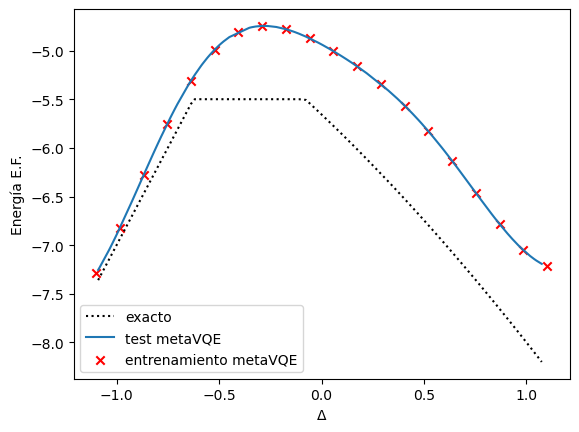

In [13]:
### GRÁFICAS META-VQE ###

plt.plot(x_test, y_test_exact, color="black", ls=":", label="exacto")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="test metaVQE")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="entrenamiento metaVQE")
plt.xlabel("Δ")
plt.ylabel('Energía E.F.')
plt.legend()
plt.show()

### Conclusiones

Observamos que el circuito es capaz de "aprender" la forma de la curva del hamiltoniano. Ahora, procedemos a la segunda optimización.

# OPT-META-VQE PARA XXZ

La filosofía del opt-meta-VQE se basa en utilizar los valores de las variables $\verb|w1|$, $\verb|w2|$, $\verb|phi|$ y $\verb|theta|$ como punto de partida para un VQE habitual. De este modo, cogemos como ángulos iniciales los obtenidos de la anterior minimización del meta-VQE y ejecutamos de nuevo el algoritmo, esta vez con una función de coste por cada uno de los valores de $\Delta$

$$ C_i(\vec{\Theta}) = \langle \varphi (\vec{\Theta}_i, \Delta_i) | H (\Delta_i) | \varphi_i (\vec{\Theta}_i, \Delta_i) \rangle $$





Calculamos sus residuos y graficamos de nuevo.

In [14]:
y_optmetaVQE = []
error_optmetaVQE = []

for i in range(len(Delta_train)):
    
    ham = hamiltonian(nqubits, Delta_train[i], lambXXZ)
    fullcircuit = quantum_circuit(nqubits, nlayers[0], Delta_train[i], "th_enc") + quantum_circuit(nqubits, nlayers[1], 0, "th_proc")
    costf = tq.ExpectationValue(H=ham, U=fullcircuit)
    
    th0 = metaVQE.angles
    
    optmetaVQE = tq.minimize(objective=costf, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods,
                            samples=None, initial_values=th0, backend=backend, noise=None, device=None, silent=True)
    
    res = optmetaVQE.energy
    res_exact = exact(nqubits, Delta_train[i], lambXXZ)
    
    y_optmetaVQE.append(res)
    error_optmetaVQE.append(abs(res - res_exact))

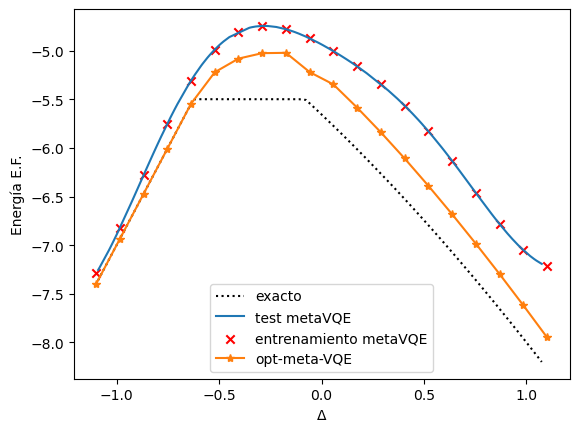

In [15]:
### GRÁFICAS OPT-META-VQE ###

plt.plot(x_test, y_test_exact, color="black", ls=":", label="exacto")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="test metaVQE")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="entrenamiento metaVQE")
plt.plot(x_train, y_optmetaVQE,  marker="*", label="opt-meta-VQE")

plt.xlabel("Δ")
plt.ylabel('Energía E.F.')
plt.legend()
plt.savefig("metaVQE-6q.svg", format="svg")
plt.show()

### Conclusiones

Observamos una clara mejoría con respecto a los resultados de la primera optimización. En valores cercanos a $\Delta = -1$ es capaz de alcanzar el valor exacto de la energía. En valores más cercanos a $\Delta = 1$, discrepa consistentemente.

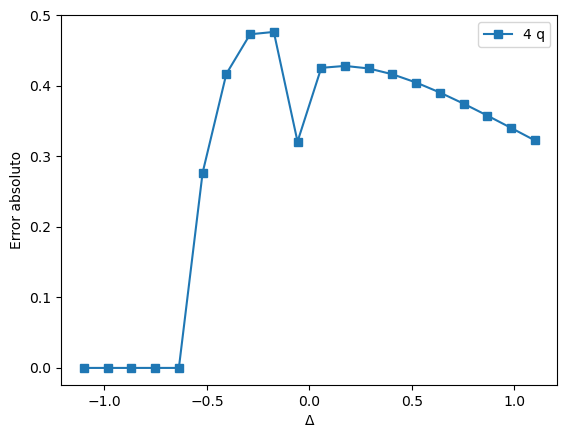

In [18]:
# ERROR ABSOLUTO

plt.plot(x_train, error_optmetaVQE, ls="-",  marker="s", color='tab:blue', label="4 q", zorder=1)

plt.xlabel("Δ")
plt.ylabel("Error absoluto")
plt.legend()
plt.savefig("error_absoluto.svg", format="svg")
plt.show()